Importing Required Libraries

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

Loading the Dataset

In [99]:
file_path = '../Datasets/adult_data.csv'

In [100]:
df = pd.read_csv(file_path)
columns_name = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df.columns = columns_name
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   workclass       32560 non-null  object
 2   fnlwgt          32560 non-null  int64 
 3   education       32560 non-null  object
 4   education-num   32560 non-null  int64 
 5   marital-status  32560 non-null  object
 6   occupation      32560 non-null  object
 7   relationship    32560 non-null  object
 8   race            32560 non-null  object
 9   sex             32560 non-null  object
 10  capital-gain    32560 non-null  int64 
 11  capital-loss    32560 non-null  int64 
 12  hours-per-week  32560 non-null  int64 
 13  native-country  32560 non-null  object
 14  income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [102]:
df.shape

(32560, 15)

Handle Missing Values

In [103]:
df.replace(' ?', np.nan, inplace=True)
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [104]:
df = df.dropna()
df.shape

(30161, 15)

In [105]:
df['income'].unique() # checking consistency in target column values

array([' <=50K', ' >50K'], dtype=object)

In [106]:
df['income'] = df['income'].str.strip()
df['income'] = df['income'].str.replace('.', '', regex=False) # fixing income column values
df['income'].unique()

array(['<=50K', '>50K'], dtype=object)

Removing Outliers

In [107]:
numerical_cols = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    df = df[(df[col] >= lower) & (df[col] <= upper)]

In [108]:
df.shape

(19064, 15)

Importance of Weekly Working Hours

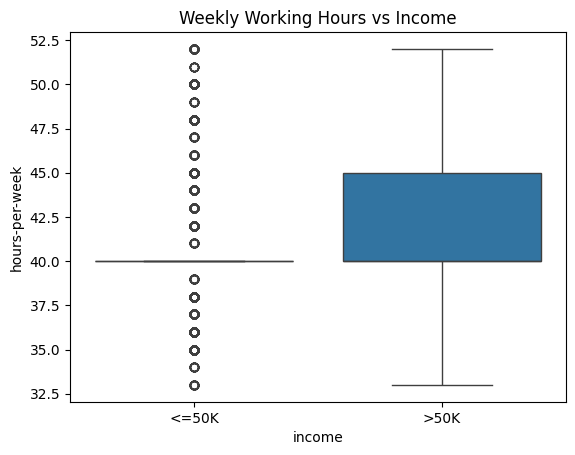

income
<=50K    41.137606
>50K     42.827904
Name: hours-per-week, dtype: float64

In [109]:
sns.boxplot(x='income', y='hours-per-week', data=df)
plt.title("Weekly Working Hours vs Income")
plt.show()
df.groupby('income')['hours-per-week'].mean()

features that are highly correlated with the earning potential

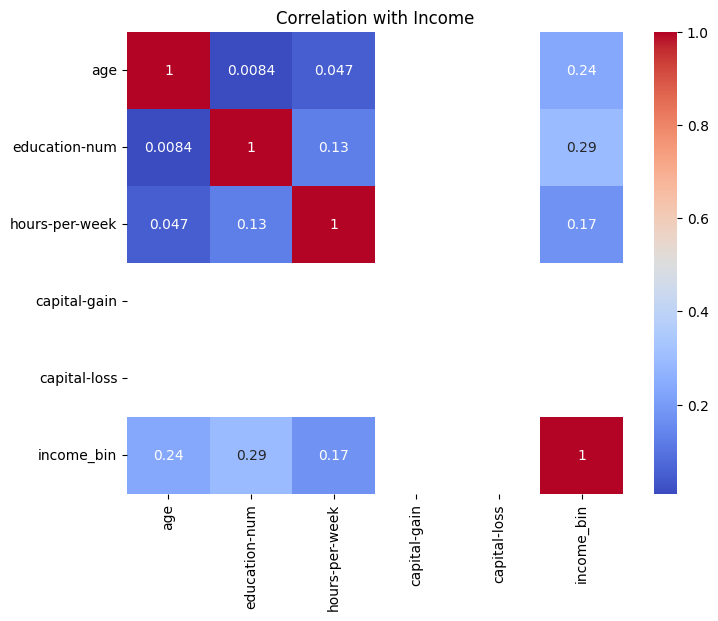

In [110]:
df['income_bin'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
corr = df[numerical_cols + ['income_bin']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation with Income")
plt.show()

In [111]:
corr = df.corr(numeric_only=True)['income_bin'].sort_values(ascending=False)
print(corr)

income_bin        1.000000
education-num     0.291314
age               0.235896
hours-per-week    0.174299
fnlwgt           -0.008107
capital-gain           NaN
capital-loss           NaN
Name: income_bin, dtype: float64


Education Years vs Earning Potential

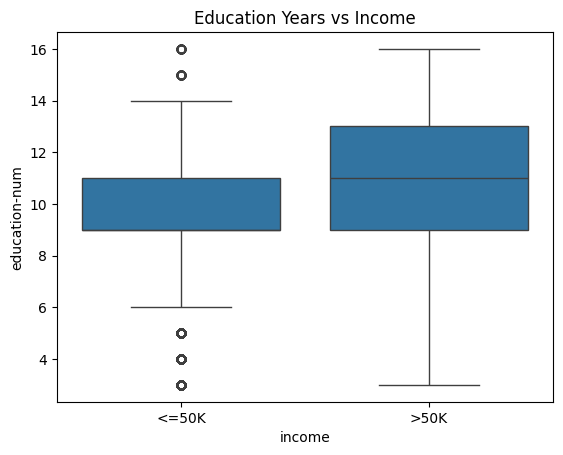

income
<=50K     9.703450
>50K     11.413579
Name: education-num, dtype: float64

In [112]:
sns.boxplot(x='income', y='education-num', data=df)
plt.title("Education Years vs Income")
plt.show()
df.groupby('income')['education-num'].mean()

Age vs Earning Potential

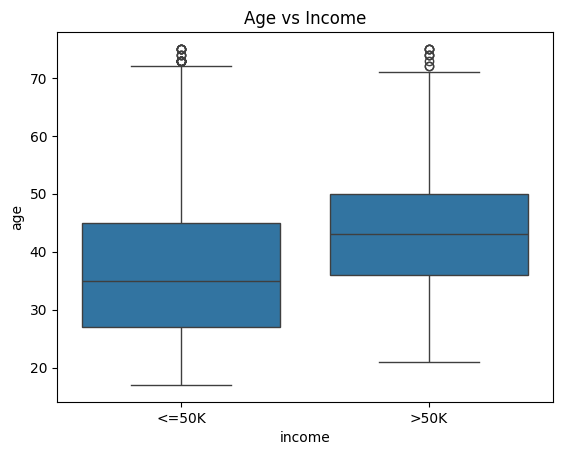

income
<=50K    36.680582
>50K     43.509575
Name: age, dtype: float64

In [113]:
sns.boxplot(x='income', y='age', data=df)
plt.title("Age vs Income")
plt.show()
df.groupby('income')['age'].mean()

In [114]:
df.drop('income', axis=1, inplace=True) # After creating income_bin, the original income column Is redundant and Should NOT be used as a feature

Feature Engineering(Categorical → Numerical)

In [115]:
X = df.drop('income_bin', axis=1)
y = df['income_bin']

In [116]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

print("Categorical columns:", list(cat_cols))
print("Numerical columns:", list(num_cols))

Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [117]:
X.shape

(19064, 14)

In [118]:
X_encoded = pd.get_dummies( # sklearn.OneHotEncoder and pd.get_dummies() are Different functions but same concept(For every categorical column, they create binary (0/1) columns for each category)
    X,
    columns=cat_cols,
    drop_first=True
)

print("Shape before encoding:", X.shape)
print("Shape after encoding:", X_encoded.shape)

Shape before encoding: (19064, 14)
Shape after encoding: (19064, 93)


Building a predictive model for the earning potential

In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols]) # Standardizing numerical features for Distance-based and linear models

In [120]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)

(15251, 93) (3813, 93)


In [121]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [122]:
y_pred = model.predict(X_test)

Accuracy: 0.8447416732231838

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      3009
           1       0.67      0.52      0.59       804

    accuracy                           0.84      3813
   macro avg       0.77      0.73      0.75      3813
weighted avg       0.84      0.84      0.84      3813



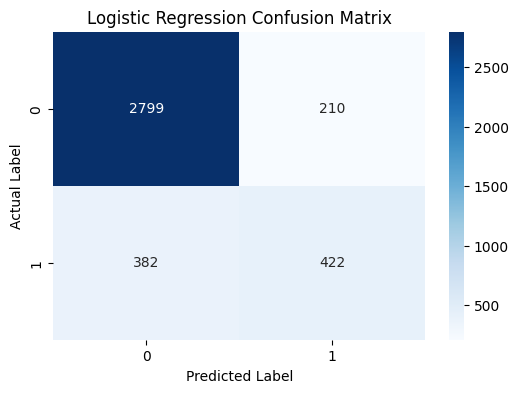

In [133]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [125]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)


In [126]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [127]:
y_pred_rf = rf_model.predict(X_test)

In [128]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.8347757671125098


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3009
           1       0.63      0.52      0.57       804

    accuracy                           0.83      3813
   macro avg       0.75      0.72      0.74      3813
weighted avg       0.83      0.83      0.83      3813



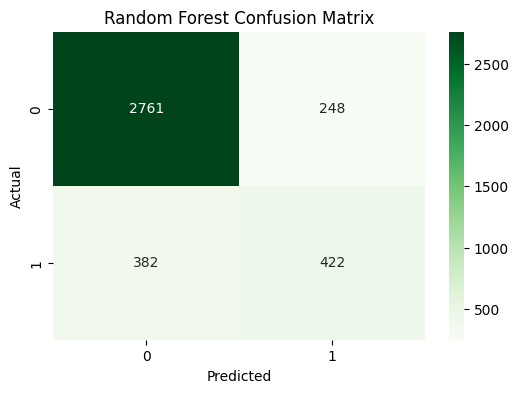

In [130]:
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


Key Business Insights:

Education level and weekly working hours significantly impact earning potential.

Individuals with higher education years have a greater likelihood of earning >50K.

Working more hours per week correlates positively with higher income.

Middle-aged individuals tend to earn more compared to very young or very old groups.

The predictive model can help organizations:

Identify high-income demographic segments

Optimize compensation strategies

Make data-driven workforce planning decisions